# Part 1

In [1]:
import numpy as np
import pandas as pd
from fastai.imports import *
from fastai.structured import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error as mae

In [2]:
def get_sample(df,n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

In [3]:
def imae(x,y): return (abs(x-y)).mean()

In [4]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

In [5]:
def print_score(m):
    maer = [imae(m.predict(X_train), y_train), imae(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): maer.append(m.oob_score_)
    print(maer)

In [6]:
def numericalize(df, col, name, max_n_cat):
    if not  pd.api.types.is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = pd.Categorical(col).codes+1

In [7]:
def fix_missing(df, col, name, na_dict):
    if  pd.api.types.is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

In [8]:
def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not pd.api.types.is_numeric_dtype(df[y_fld]): df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

In [9]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

# Part 2

In [10]:
TRAIN_FILE='/home/thiago.martinelli/code/main/data/pubg/train_V2.csv'
TEST_FILE='/home/thiago.martinelli/code/main/data/pubg/test_V2.csv'

In [12]:
df_raw = pd.read_csv(TRAIN_FILE, engine='python')

In [13]:
train_cats(df_raw)

In [ ]:
display_all(df_raw.head().T)

In [17]:
df_tr, _, _= proc_df(df_raw, subset = 100000)

In [ ]:
for i in df_tr.columns:
    f, ax = plt.subplots()
    plt.scatter(y_tr[:1000], df_tr[:1000][i], s=4)
    plt.title(i)

# adfjv aflsfuoais fuoaisfudasfiuadsfi

## adlsfkj lasdfjdklfjlasfkj klfjafk

In [125]:
m = RandomForestRegressor(n_jobs=-1, n_estimators = 1)
for i, ndf in dfa.groupby(level=0):
    m.fit(ndf.drop(['winPlacePerc'],axis=1), ndf['winPlacePerc'])
    print_score(m)

[0.312052836, 0.31665131, -0.5887046319803089, -0.6203422733652855]
[0.3359931359999999, 0.34074696000000004, -0.8677417971553438, -0.9006607022559476]
[0.399445936, 0.40480986, -1.5834898398053858, -1.6264314988759558]
[0.309591684, 0.31458789000000004, -0.5099594030150436, -0.5441190871221002]
[0.280523216, 0.28171857000000006, -0.1992142267270567, -0.20201370986303324]
[0.389802846, 0.3967901, -1.4698269675797007, -1.5268563623831897]
[0.32052438400000005, 0.32531506, -0.6847825514529993, -0.7219965826311885]
[0.306520264, 0.31061714, -0.5221138896714452, -0.54776149512139]
[0.444809584, 0.4505486000000001, -2.073338856609296, -2.1211684403852833]
[0.31309196, 0.31800173, -0.593404833965131, -0.6309931233516779]
[0.28857027600000007, 0.29118103999999995, -0.35546857051662206, -0.37226343582837607]
[0.32567875, 0.33032709000000005, -0.7466294011628867, -0.7760751463134077]
[0.28721838, 0.29082631000000003, -0.27038165144983495, -0.29349147431886924]
[0.277093532, 0.27950474000000003,

KeyboardInterrupt: 

## adlsfkj lasdfjdklfjlasfkj klfjafk

In [98]:
m = RandomForestRegressor(n_jobs=-1, n_estimators = 10 )
for i, ndf in dfa.groupby(level=0):
    match0 = ndf
    break

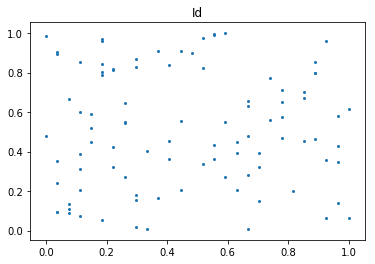

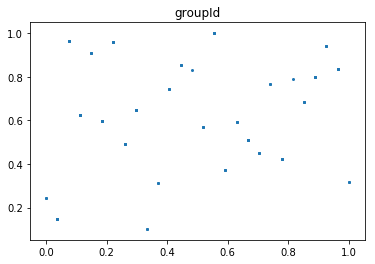

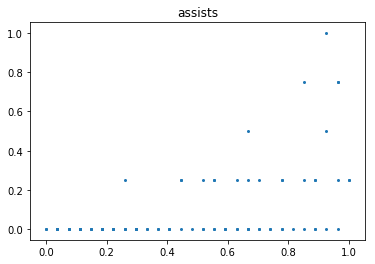

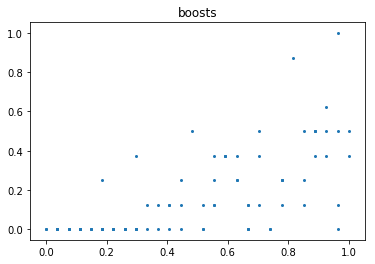

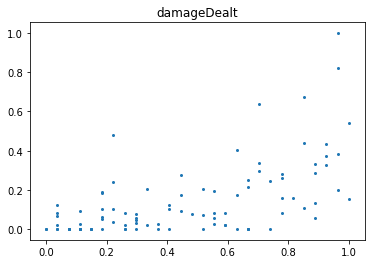

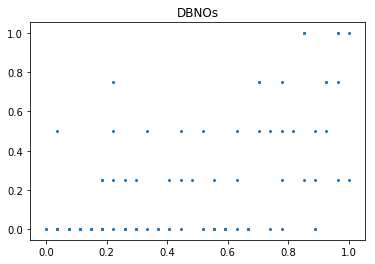

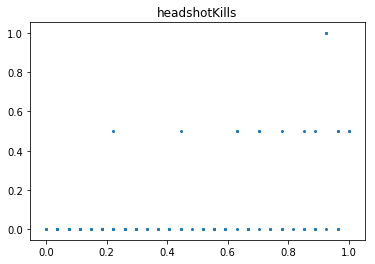

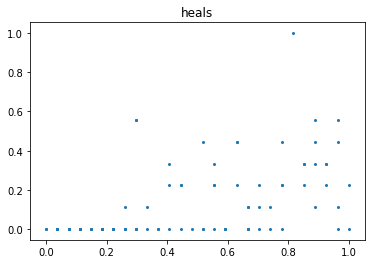

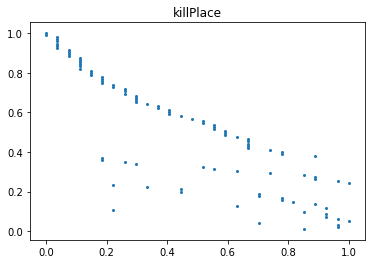

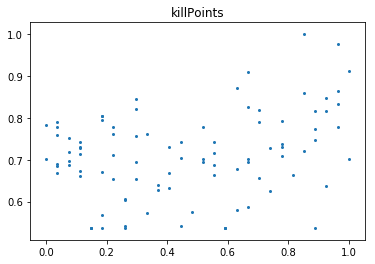

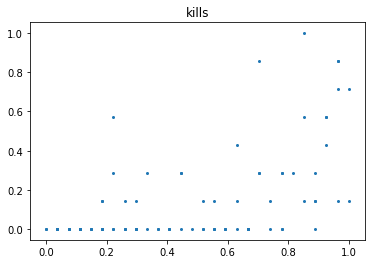

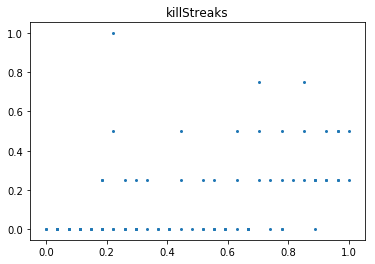

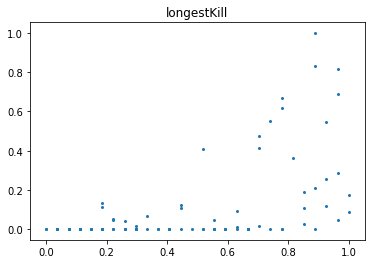

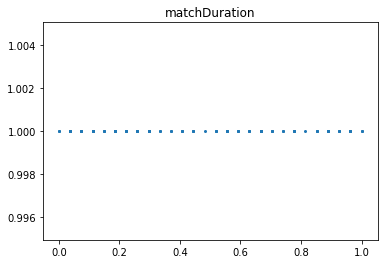

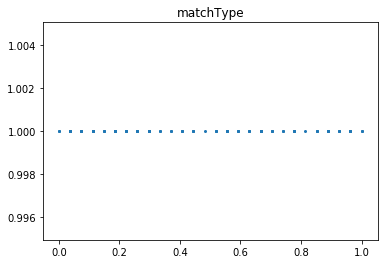

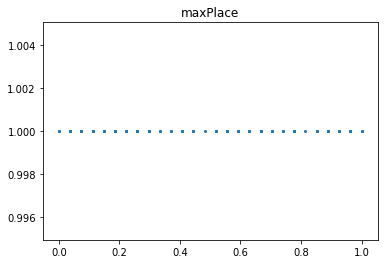

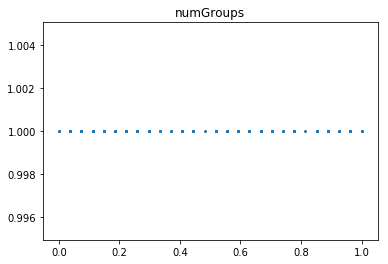

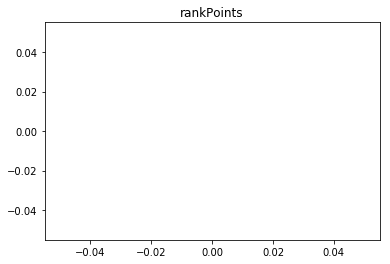

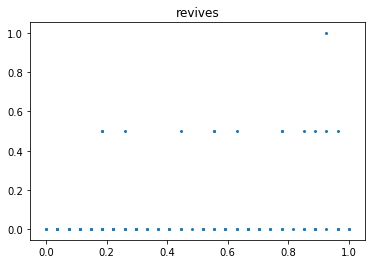

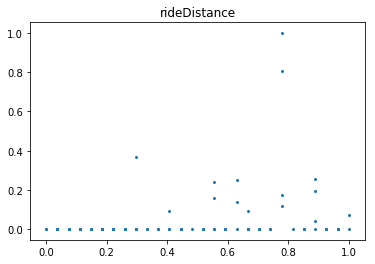

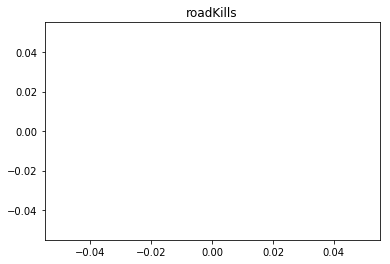

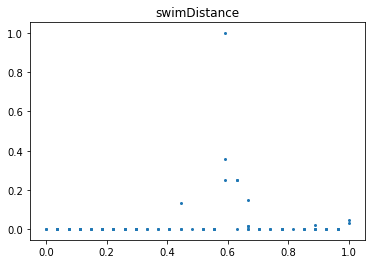

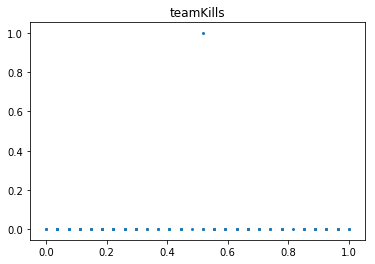

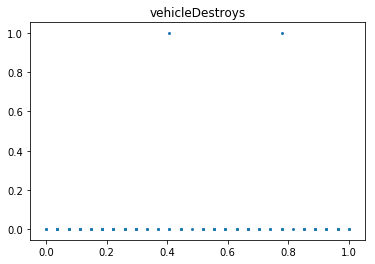

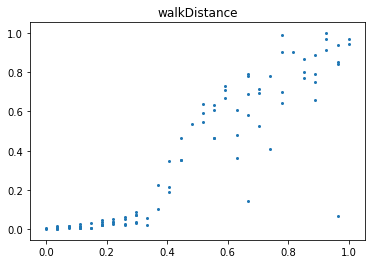

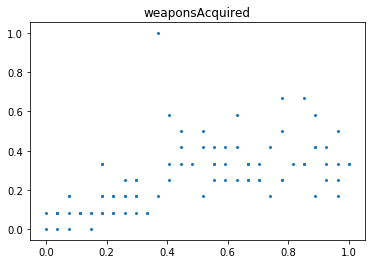

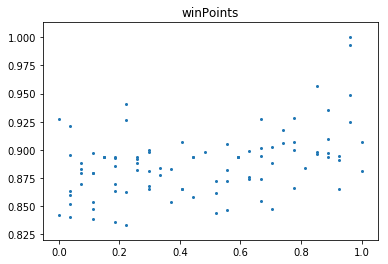

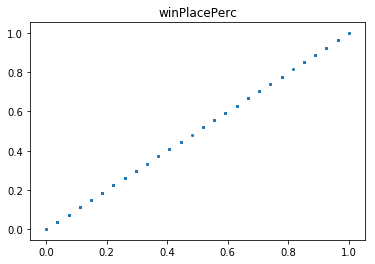

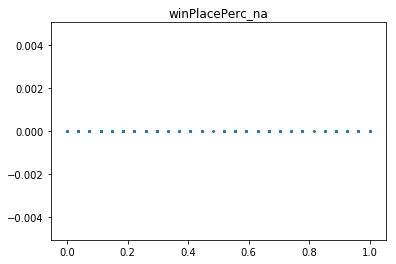

In [121]:
for i in match0.columns:
    f, ax = plt.subplots()
    plt.scatter(match0['winPlacePerc'], match0[i], s=4)
    plt.title(i)

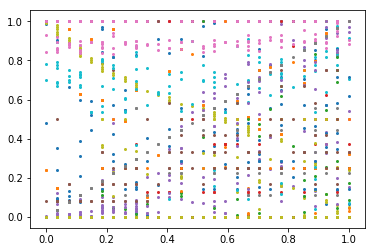

In [124]:
for i in match0.columns:
    plt.scatter(match0['winPlacePerc'], match0[i], s=4)


## adlsfkj lasdfjdklfjlasfkj klfjafk

In [22]:
df = df_tr

In [29]:
df.set_index(['matchId'],inplace=True)

In [30]:
df.sort_index(inplace=True)

In [31]:
display_all(df.head(50))

,Id,groupId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
matchId,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4040552,603064,0,1,23.400,0,0,0,59,1167,0,0,0.000,1346,16,28,28,0,0,0.00,0,0.000,0,0,770.40,12,1483,0.3704
1,3549925,1527915,1,4,324.800,2,1,3,13,1521,2,1,192.500,1346,16,28,28,0,0,87.67,0,0.000,0,0,2575.00,7,1571,0.8889
1,4396726,1916779,1,3,189.900,0,0,2,51,1333,0,0,0.000,1346,16,28,28,0,1,352.00,0,0.000,0,0,1604.00,4,1481,0.5556
2,4108754,1776742,0,1,187.100,1,0,2,33,0,1,1,43.870,1363,16,28,27,1488,0,0.00,0,0.000,0,0,804.60,5,0,0.5185
3,2799341,1775636,0,0,44.650,0,0,1,79,0,0,0,0.000,1949,13,95,92,1513,0,0.00,0,0.000,0,0,245.90,2,0,0.1702
3,676675,1544254,0,0,0.000,0,0,0,92,0,0,0,0.000,1949,13,95,92,1500,0,0.00,0,0.000,0,0,16.27,0,0,0.0106
3,2671123,571535,0,0,0.000,0,0,0,95,0,0,0,0.000,1949,13,95,92,1451,0,0.00,0,0.000,0,0,15.93,0,0,0.0000
4,3739963,2021154,0,1,0.000,0,0,0,70,0,0,0,0.000,1410,3,50,47,1470,0,0.00,0,0.000,0,0,275.70,2,0,0.3061
4,20420,1416472,0,0,0.000,0,0,0,62,0,0,0,0.000,1410,3,50,47,1478,0,0.00,0,0.000,0,0,738.60,1,0,0.4490


In [32]:
df.index.value_counts()

39776    12
33982    10
36013     9
36015     9
37492     9
36251     9
16532     9
30578     9
23682     9
6414      9
17210     9
14175     8
36077     8
19182     8
44261     8
42004     8
29460     8
12743     8
31842     8
8141      8
24173     8
29967     8
4677      8
1826      8
38368     8
26518     8
25038     8
435       8
22968     8
22814     8
         ..
41347     1
43394     1
45441     1
47488     1
18782     1
24923     1
21694     1
2390      1
8531      1
44257     1
35142     1
37189     1
34020     1
18718     1
40167     1
15603     1
7415      1
10514     1
17660     1
39172     1
20701     1
26842     1
215       1
12497     1
35014     1
43202     1
45249     1
16543     1
20637     1
2047      1
Name: matchId, Length: 41849, dtype: int64

## adlsfkj lasdfjdklfjlasfkj klfjafk

In [246]:
dfall = df_raw.set_index(['matchId'],drop=False)

In [247]:
%time dfa, _, _ = proc_df(dfall)

CPU times: user 10.4 s, sys: 5.43 s, total: 15.8 s
Wall time: 16 s


In [248]:
%%time
c=0
matches=pd.DataFrame()

for i, ndf in dfa.groupby(level=0):
    print(c,end="\r")
    c+=1 
    matches=pd.concat((matches,ndf),axis=0)
    if c == 10:
        break

In [254]:
len(set(matches.index))

10

In [52]:
matches.head()

,Id,groupId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,...,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,winPlacePerc_na
matchId,,,,,,,,,,,,,,,,,,,,,
0000a43bce5eec,2798432,982090,0,1,0.0,0,0,1,41,1693,...,0.0,0,0.000,0,0,2723.0,3,1502,0.6667,False
0000a43bce5eec,293764,612351,1,3,151.8,1,1,2,23,1308,...,159.9,0,6.545,0,0,3250.0,4,1480,1.0000,False
0000a43bce5eec,3502335,1147078,0,0,185.3,0,0,0,34,1496,...,0.0,0,0.000,0,0,155.7,2,1499,0.1852,False
0000a43bce5eec,1999491,1131961,0,2,0.0,0,0,4,45,1263,...,0.0,0,0.000,0,0,1241.0,3,1471,0.6296,False
0000a43bce5eec,2992680,1310968,0,4,432.4,4,0,3,1,1599,...,0.0,0,0.000,0,0,2762.0,4,1505,0.8519,False


In [255]:
matches.shape

(962, 30)

In [218]:
a=np.array([8,7,6,5,4,3,322,12])
a.sort()

In [219]:
np.where(a==7)

(array([4]),)

In [256]:
def rank(a):
    b = np.asarray(list(set(np.sort(a))))
    for n,i in enumerate(a):
        a[n] = np.where(b==i)[0]
    return a
  
    

In [257]:
mt=matches.copy()

In [258]:
len(set(mt.index))

10

In [259]:
def feat_eng(df,cols):
    newdf = pd.DataFrame()
    %time
    count=0
    for i, ndf in df.groupby(level=0):
        count+=1
        print(count, end='\r')
        for c in cols:
            serie=ndf[c]
            rank(np.asarray(serie))
            ndf[c + 'Pos'] = serie
        newdf = pd.concat( (newdf, ndf), axis=0)
    return newdf

In [ ]:
def test(dff,cols):
    newdf = pd.DataFrame()
    %time
    count=0
    for i, ndf in dff.groupby(level=0):
        count+=1
        print(count, end='\r')
        print(i)
    print(c)

In [234]:
cols = list(['assists', 'boosts', 'damageDealt', 'DBNOs', \
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills', \
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace', \
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills', \
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance', \
       'weaponsAcquired', 'winPoints'])


In [235]:
mt.shape

(962, 29)

In [242]:
matches.head()

,Id,groupId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,...,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,winPlacePerc_na
matchId,,,,,,,,,,,,,,,,,,,,,
0000a43bce5eec,2798432,982090,0,1,0.0,0,0,1,41,1693,...,0.0,0,0.000,0,0,2723.0,3,1502,0.6667,False
0000a43bce5eec,293764,612351,1,3,151.8,1,1,2,23,1308,...,159.9,0,6.545,0,0,3250.0,4,1480,1.0000,False
0000a43bce5eec,3502335,1147078,0,0,185.3,0,0,0,34,1496,...,0.0,0,0.000,0,0,155.7,2,1499,0.1852,False
0000a43bce5eec,1999491,1131961,0,2,0.0,0,0,4,45,1263,...,0.0,0,0.000,0,0,1241.0,3,1471,0.6296,False
0000a43bce5eec,2992680,1310968,0,4,432.4,4,0,3,1,1599,...,0.0,0,0.000,0,0,2762.0,4,1505,0.8519,False


In [237]:
newdf = test(mt,cols)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 15.5 µs
0000a43bce5eec
0000eb01ea6cdd
0002912fe5ed71
0003b92987589e
0006eb8c17708d
00077604e50a63
00086c74bb4efc
00086e740a5804
001125344b660c
001360264d4b5f
0014d9d1b0aff6
001616ed5da99b
0016fe3ee17ce7
00177a6ce4dfb5
00188d50e054f5
001937f739426c
0019bc34b3c58e
0019d729577e9c
001cd8e7e6b737
001e5e4799a31c
001e7bc06b1611
001eeedf57047a
00200fe5d9aae5
0022adebf59be6
0022e660571ee8
00232f9d9c5421
0025477f88bbd9
002771bd25fe0e
0027a504cd3b0c
0027b1ffb2e346
002aeef57764f8
002af9fec8e1e8
002b3b8e0e3870
003228f5dc4934
0032986e32b6ce
00335f974fb508
0039ac593fdb48
003a7ce862fa03
003b6b0d02a30f
003c2b333747d9
003dde2a3cfe21
0043d1bf58fcab
0043d584520de4
00443dc542d36f
004491afc66da5
0044d2e8f90a9c
004760d4b1aa7e
00489048e21690
004cddec9da619
004d5cbd41b845
004d71d7e987ef
004fb5a1da0f97
005166f6ee4ab6
0052116de68e46
0052ab0d129257
0055b5c097ed61
005712df62d721
005908fb69efc4
0059939eb6ba30
005aca992c9a78
005c6a0d0e7d6c
005e236012c55f
005e3f

036a92f1e7c0d9
036ba03edd06ff
036cc78bab33cf
037516ed0a0f86
03767881d5ec22
03776a4c4a05ae
0377781a6a13cd
0377b3e6e0c72b
037865e5d6092c
037a67fe3c643b
037b880085be85
037c003682840c
037c04f981fec5
037c1dda299c1b
037d5f1a17d8b3
037e578e618511
037f3d34ae88d7
03837acc3e5610
03849a10902b79
0386f79c3d73f3
038c8c6f225ad5
038cac04b3403a
038edd8d58753a
038f2e72843958
0390f27c513a57
0392d78742b681
03944bf553840c
039b0c8539b9b7
039d2e437c57c3
039d5e3668e8a8
039f2da58a00fd
039fc7c27035f9
03a111b28f5fa3
03a1cf8571feb8
03a24daa0f3e65
03a2a1048034d3
03a655a35d7bd4
03a8137ff784a1
03a90bd494cb8d
03a9920639776e
03aa18c04e1470
03ab2914713c76
03ac9b981ab922
03ad4eaa8bd8c3
03ae4a00c795c5
03b003ef12d95b
03b09f75599866
03b2aaf71899dd
03b4eea5ae6d8d
03b5f8dcd17813
03b64fdf6e8d81
03b774672e7e83
03bab20f9dd504
03bae0d85d988c
03bbbbfbc57208
03bce32d2976ce
03be1419c48895
03be41225eed32
03beef57ecb37e
03c29e67e92fa1
03c32bb3968450
03c5f8fcfd423b
03c7df50180520
03cac55371b9e5
03cd461034056c
03cf02ad34de1e
03d2ea6542

06c5ec862480e1
06c67c84809933
06c6fbdb62c73e
06c76dec401179
06c79062b2983e
06cb22535d99ab
06cde0b9ca31f1
06d0ebc5181d7a
06d378e13ba8c5
06d395e447e4e5
06d3fd460bc687
06d4caacaf9ada
06d77818869f29
06daf4bfe4549a
06dc1e61cc90ce
06dcbababbb39b
06def1c4d808d4
06dfc2881204bf
06e013b96cbb9b
06e06f471ef200
06e15cbc94b006
06e1c4e1f9cdd5
06e2b98258ad78
06e3c9919fc418
06e4665ac55cc1
06e52d5e3ca2be
06e9a05ca51a0f
06ea5a95eef646
06f156aa5489ec
06f1959bad07f6
06f1a79fac14d8
06f72cfe9273eb
06f853dab32a20
06f8d94de95813
06f8e68581af8d
06f937e1339966
06fa30902a4787
06ff3c9d741d8e
06ffbd432880f0
0700f04a1f3f1c
070290cc13726d
0702b1fc1bc56b
070571f67950ea
0708e0ec13d870
070ae7fa87ed22
070d52d7ecd77b
070ea9fd65148c
070fb4e698dc43
0711b693d1bad9
0712e76727bc53
071312a17716db
0713aac7df0612
071551223fa50b
071650c30747c8
0717691ec5b356
07186ccde12884
071ae432c8bcf0
071af791c1549f
071e483f5d8917
07200cf8183b31
0720ed9df17a16
0721fe7199949c
07225110b1b6f1
0722d668468cb3
0726474798aab3
0728b2b85fdd60
0729ae4719

0a2f3456da50e2
0a2fd1b28bac2b
0a32f1ad3cbe10
0a3334bab5cac7
0a34554d43a9a0
0a35c16643ad79
0a36d84a6ce2b6
0a37aecde5ce77
0a390f1161c574
0a3975ee72ff75
0a3c9395fa3475
0a4131d3b3831c
0a4299c01d3778
0a42f5450ccc91
0a433e261f8a91
0a4360af526dc4
0a4568b390cce9
0a457e688ac08f
0a499afda636f7
0a4a584a6c869d
0a4aa1aea4d554
0a4d81207fe5d6
0a4dbd262efe98
0a4fa7f36b9ffe
0a500e41fd6d2c
0a501dd75df44f
0a5033659fe215
0a509cbed3fb09
0a50fa59031083
0a5200d50aff67
0a524189241f21
0a529937b72cec
0a53445f7c79e3
0a5449e83c7244
0a54b20f832d7b
0a580cc6d43faa
0a58d89de046cc
0a5b45d5f6a360
0a5cadf52e7e18
0a5d4cb54b573f
0a5e7ed6fc52f5
0a5ea252ce26be
0a60703351d7a7
0a62c402607a71
0a65ee86e27dc5
0a66417e22d523
0a689151495ccd
0a69324b1087bd
0a69842fd9863e
0a6aeaa40254a8
0a6b329195c5e8
0a6c711c7ebb4d
0a6d53f2e60714
0a6e7b5e1207a4
0a709b20548e0c
0a724b6d7e72a2
0a72b74872a008
0a78360f1a3b5f
0a7974ace9d28e
0a79ae3749fbdc
0a7a7e1e2327f0
0a7b4e13d6ed66
0a7b4fe2f7b052
0a7ba869dc72de
0a7e69292549f0
0a7ef56d27f0ff
0a7f8a4d50

0d5b27da769c27
0d5b979eafe59b
0d5d5e34871171
0d5d878cdda0e3
0d5d978d75e43c
0d5e7f486caca6
0d6030ec46cd00
0d67de74ed8538
0d6911a7161004
0d6f6a6ce15c80
0d708e31029d18
2495

KeyboardInterrupt: 

In [226]:
newdf = feat_eng(mt,cols)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.4 µs


/home/thiago.martinelli/venvs/p36/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


KeyboardInterrupt: 

In [201]:
mt.shape

(92564, 29)